# Lab 2: Density Estimation

Import and explore the data, implements python functions to (i) estimate density distributions from the data, and (ii) predict classes using the estimated density distributions. Submit this notebook to eclass with the name "lab1_123456.ipynb" and replace "123456" by the ID you used for the first lab.

Import the libraries you will use for this lab:

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

Import the data in "DensitiEstimationDataset.mat" and "GlassClassification.csv" datasets

In [63]:
mat = scipy.io.loadmat('DensityEstimationDataset.mat') #read scipy.io.loadmat() documentation if necessary, check what are you exactly importing here
#you can use pandas to import GlassClassification.csv
X1 = mat['DensityEstimationDataset'][:, :2]
y1 = mat['DensityEstimationDataset'][:, 2].astype(int).flatten()

df = pd.read_csv('GlassClassification.csv')

X2 = df.iloc[:, :4].values
y2 = df.iloc[:, 4].astype(int).values

Check the classes for each of the datasets

In [64]:
f"Para o .mat: {set(y1)}; Para o Glass: {set(y2)}"

'Para o .mat: {np.int64(0), np.int64(1), np.int64(2)}; Para o Glass: {np.int64(1), np.int64(2)}'

Divide your dataset into training and testing sets

In [65]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.80, random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.80, random_state=42)

Create a function that estimate gaussian distributions for each class. Think that the output your function generates needs to be useful for you to predict for new points.

In [66]:
def GDE(Xtrain, ytrain):
    """
    Estimates Gaussian parameters (mean, covariance, and prior) for each class.

    Parameters:
      Xtrain : ndarray of shape (n_samples, n_features)
      ytrain : ndarray of shape (n_samples,)

    Returns:
      model : dict with keys equal to class labels and values equal to tuples (mu, cov, prior)
    """
    classes = np.unique(ytrain)
    models = {}
    n_samples = Xtrain.shape[0]

    for c in classes:
        # select points that belong to class c
        indices = (ytrain == c)
        Xc = Xtrain[indices]

        # estimate mean
        mu = np.mean(Xc, axis=0)

        # estimate variance (or covariance)
        cov = np.cov(Xc, rowvar=False)

        # estimate prob for the class
        p_class = Xc.shape[0] / float(n_samples)  # relative frequency as the class prior

        models[c] = (mu, cov, p_class)

    return models

Analize the output of your function and built another one that can use that output to predict the class for a new set of points.

In [67]:
def MGaussian(x, mu, cov):
    """
    Computes the multivariate Gaussian probability density for each row in X.

    Parameters:
      x   : ndarray of shape (n_features,) the feature vectors
      mu  : ndarray of shape (n_features,) the mean vector
      cov : ndarray of shape (n_features, n_features) the covariance matrix (or sigma**2)

    Returns:
      pdf_values : ndarray of shape (n_samples,)
    """

    # constant term
    d = x.shape[0]

    cov_inv = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    norm_const = 1. / np.sqrt((2 * np.pi)**d * det_cov)

    # exponent term
    diff = x - mu

    diff = diff.reshape(len(diff), 1)

    exponent = -0.5 * (diff.T @ cov_inv @ diff)

    # compute the pdf
    pdf_value = norm_const * np.exp(exponent)

    return pdf_value

def predG(model, Xtest):
    """
    Predicts the class label for each test example using the Gaussian model.

    Parameters:
      model : output of the GDE function (dict mapping classes to parameters)
      Xtest : ndarray of shape (n_test_samples, n_features)

    Returns:
      predictions : ndarray of predicted class labels of length n_test_samples
    """
    predictions = []

    for x in Xtest:
        class_scores = {}
        # for each class, calculate the bayes teorem
        for c in model.keys():
            mu, cov, p_class = model[c]
            # use MGaussian to calculate p(x|c)
            pdf_val = MGaussian(x, mu, cov)[0]

            # numerator of Bayes theorem (we don't need to calculate the denominator, it is the same for each class)
            class_scores[c] = pdf_val * p_class

        # choose the class with maximum p(c|x)
        predicted_class = max(class_scores, key=class_scores.get)
        predictions.append(predicted_class)

    return np.array(predictions)

Create a function that predicts the class of a point using the histogram of the points in the training set. This function does not "learn" a model, is directly a predictor of the point class.

In [68]:
def predH(Xtrain, ytrain, Xtest, nbins):
    def predH_point(Xtrain, ytrain, point, nbins):
        """
        Predicts the class label for a given point using a histogram-based approach.
        The feature space is divided into 'nbins' bins per dimension.

        Parameters:
        Xtrain : ndarray of shape (n_samples, n_features) used to build the histogram
        ytrain : ndarray of shape (n_samples,) with training class labels
        point  : ndarray of shape (n_features,) for which the class is predicted
        nbins  : int, number of bins for each feature dimension

        Returns:
        predicted_class : the predicted class label for 'point'
        """
        n_features = Xtrain.shape[1]
        bins = []  # Will contain bin edges for each dimension

        # Calculate equal-width bin edges for each feature using the training data.
        for j in range(n_features):
            min_val = np.min(Xtrain[:, j])
            max_val = np.max(Xtrain[:, j])
            # Create nbins+1 edges (this defines nbins bins)
            edges = np.linspace(min_val, max_val, nbins + 1)
            bins.append(edges)

        bins = np.array(bins)  # Shape: (n_features, nbins+1)

        # Determine the bin index for each dimension of the 'point'
        point_bin = []
        for j in range(n_features):
            # np.digitize returns indices starting at 1; subtract 1 for 0-based index.
            bin_index = np.digitize(point[j], bins[j]) - 1
            # Adjust if point equals the maximum value
            if bin_index == nbins:
                bin_index = nbins - 1
            point_bin.append(bin_index)
        point_bin = np.array(point_bin)

        # Determine the bin indices for each point in the training set for each feature.
        Xbins = []
        for j in range(n_features):
            # Again subtract 1 to get 0-based indices.
            col_bins = np.digitize(Xtrain[:, j], bins[j]) - 1
            Xbins.append(col_bins)
        # Stack to form an array of shape (n_samples, n_features)
        Xbins = np.stack(Xbins, axis=-1)

        # Identify the training points that fall into the same bin as the 'point'
        same_bin_mask = np.all(Xbins == point_bin, axis=1)

        if np.sum(same_bin_mask) == 0:
            # If no training point falls in the same bin, one option is to default to the majority class of the training set.
            unique, counts = np.unique(ytrain, return_counts=True)
            predicted_class = unique[np.argmax(counts)]
            return predicted_class
        else:
            # Use the majority vote from the points falling into the same bin.
            subset_labels = ytrain[same_bin_mask]
            unique, counts = np.unique(subset_labels, return_counts=True)
            predicted_class = unique[np.argmax(counts)]
            return predicted_class

    return np.array([predH_point(Xtrain, ytrain, x, nbins) for x in Xtest])


Build an accuracy function (you can use the one you built for the 1st lab). It should output the overall accuracy and the accuracy per class. 

In [69]:
def acc(pred, target):
    # accuracy = number of correct predictions / total number of predictions
    accuracy = np.count_nonzero(pred == target)  / len(target)
    return accuracy

Build a loss matrix function, the output should clearly express the meaning of the matrix to the user. 

In [70]:
def loss_matrix(pred, y, L=None):
    """
    Computes the total loss given predictions and true labels based on a provided loss matrix.

    Parameters:
      pred : array-like, predicted class labels
      y    : array-like, true class labels
      L    : 2D ndarray representing the loss matrix.
             If None, a default 0/1 loss matrix is used (0 for correct classification, 1 for error).
             The loss matrix should be organized such that L[i,j] is the loss incurred for true label i when predicting j.

    Returns:
      total_loss : the cumulative loss over all predictions.
    """
    pred = np.array(pred)
    y = np.array(y)

    # obtain the values for each class (in numerical order)
    classes = sorted(np.unique(y))

    # map each class to an index (0, 1, 2, ...), beacuse the class values can be, for exemple (10, 20, 30 ...)
    mapping = {c: i for i, c in enumerate(classes)}

    # if no loss matrix is provided, use 0 for correct and 1 for incorrect.
    if L is None:
        n = len(classes)
        L = np.ones((n, n)) - np.eye(n)

    total_loss = 0.0
    # sum loss for each prediction
    for yt, yp in zip(y, pred):
        total_loss += L[mapping[yt], mapping[yp]]

    return total_loss

Use your functions to predict and evaluate for the DensityEstimationDataset below.

In [71]:
# -----------------------------
# Gaussian-based Prediction
# -----------------------------
model = GDE(X1_train, y1_train)
predictions_gaussian = predG(model, X1_test)

loss = loss_matrix(predictions_gaussian, y1_test)

accuracy = acc(predictions_gaussian, y1_test)

print("Gaussian-based predictions:", predictions_gaussian)
print("Accuracy for Gaussian predictions:", accuracy)
print("Total loss for Gaussian predictions:", loss, "\n")

# -----------------------------
# Histogram-based Prediction
# -----------------------------
nbins = 10
predictions_hist = predH(X1_train, y1_train, X1_test, nbins)

loss = loss_matrix(predictions_hist, y1_test)

print("Histogram-based predictions", predictions_hist)
print("Accuracy for Histogram-based predictions:", acc(predictions_hist, y1_test))
print("Total loss for Histogram-based predictions:", loss)

Gaussian-based predictions: [0 1 0 ... 1 1 1]
Accuracy for Gaussian predictions: 0.93375
Total loss for Gaussian predictions: 159.0 

Histogram-based predictions [0 1 0 ... 1 1 1]
Accuracy for Histogram-based predictions: 0.90375
Total loss for Histogram-based predictions: 231.0


Think of proper plots to show your results for each dataset. All plots should contain labels and titles describing the results.

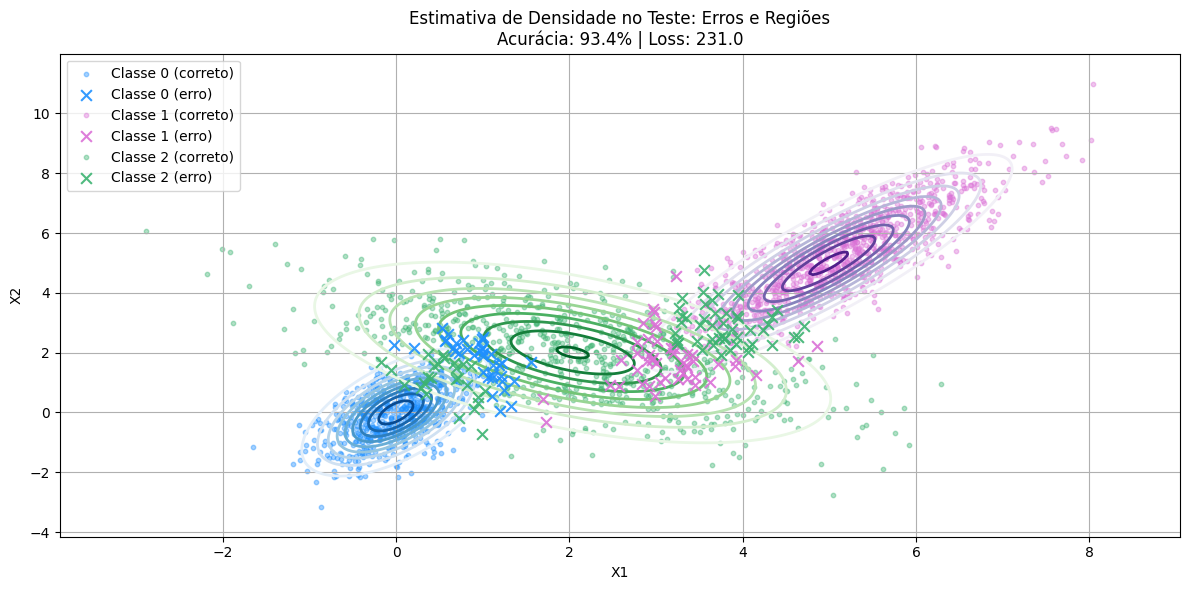

In [72]:
# Paleta alternativa
point_colors = ['dodgerblue', 'orchid', 'mediumseagreen']
contour_colors = ['Blues', 'Purples', 'Greens']
class_labels = sorted(model.keys())

# Geração do grid
x = np.linspace(np.min(X1_test[:,0]) - 1, np.max(X1_test[:,0]) + 1, 300)
y = np.linspace(np.min(X1_test[:,1]) - 1, np.max(X1_test[:,1]) + 1, 300)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

plt.figure(figsize=(12, 6))

# Contornos de densidade por classe
for idx, c in enumerate(class_labels):
    mu, cov, _ = model[c]
    Z = np.array([MGaussian(p, mu, cov) for p in pos.reshape(-1, 2)])
    Z = Z.reshape(X.shape)
    plt.contour(X, Y, Z, levels=10, cmap=contour_colors[idx], alpha=1, linewidths=2)

# Plotar pontos de teste: o se classificado corretamente, X se erro
for idx, c in enumerate(class_labels):
    idx_class = y1_test == c
    correct = (predictions_gaussian == y1_test) & idx_class
    incorrect = (predictions_gaussian != y1_test) & idx_class

    # Pontos corretos
    plt.scatter(
        X1_test[correct, 0], X1_test[correct, 1],
        c=point_colors[idx],
        label=f'Classe {c} (correto)',
        alpha=0.4,
        s=10,
        marker='o'
    )

    # Pontos incorretos
    plt.scatter(
        X1_test[incorrect, 0], X1_test[incorrect, 1],
        c=point_colors[idx],
        label=f'Classe {c} (erro)',
        alpha=0.9,
        s=60,
        marker='x',
        zorder=10
    )

# Finalização
plt.title(f'Estimativa de Densidade no Teste: Erros e Regiões\nAcurácia: {accuracy*100:.1f}% | Loss: {loss}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Use your functions to predict and evaluate for the Glass Classification dataset here

In [73]:
# -----------------------------
# Gaussian-based Prediction
# -----------------------------
model = GDE(X2_train, y2_train)
predictions_gaussian = predG(model, X2_test)

loss = loss_matrix(predictions_gaussian, y2_test)

print("Gaussian-based predictions:", predictions_gaussian)
print("Accuracy for Gaussian predictions:", acc(predictions_gaussian, y2_test))
print("Total loss for Gaussian predictions:", loss, "\n")

# -----------------------------
# Histogram-based Prediction
# -----------------------------
nbins = 10
predictions_hist = predH(X2_train, y2_train, X2_test, nbins)

loss = loss_matrix(predictions_hist, y2_test)

print("Histogram-based predictions", predictions_hist)
print("Accuracy for Histogram-based predictions:", acc(predictions_hist, y2_test))
print("Total loss for Histogram-based predictions:", loss)

Gaussian-based predictions: [1 1 1 1 2 2 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1]
Accuracy for Gaussian predictions: 0.9
Total loss for Gaussian predictions: 4.0 

Histogram-based predictions [1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1]
Accuracy for Histogram-based predictions: 0.8
Total loss for Histogram-based predictions: 8.0


Think of proper plots to show your results for each dataset. All plots should contain labels and titles describing the results.

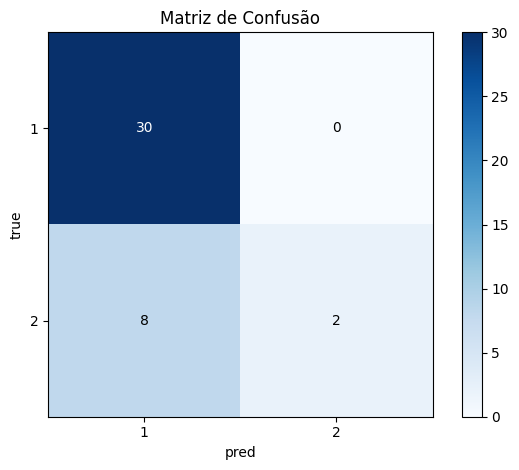

In [74]:
def confusion_matrix_custom(y_true, y_pred):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for t, p in zip(y_true, y_pred):
        i, j = np.where(labels == t)[0][0], np.where(labels == p)[0][0]
        cm[i, j] += 1

    return cm, labels

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel="pred", ylabel="true", title="Matriz de Confusão")

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    fig.colorbar(im)
    plt.tight_layout()
    plt.show()

cm, labels = confusion_matrix_custom(y2_test, predictions_hist)
plot_confusion_matrix(cm, labels)


Experiment with different number of bins for your histogram-based predictor. Plot this experiment to show how the performance behave for the different values.

In [75]:
# Experiment with different numbers of bins
nbins_range = range(1, 21)
accuracies = []

for nbins in nbins_range:
    predictions_hist = predH(X1_train, y1_train, X1_test, nbins)
    accuracy = acc(predictions_hist, y1_test)
    accuracies.append(accuracy)

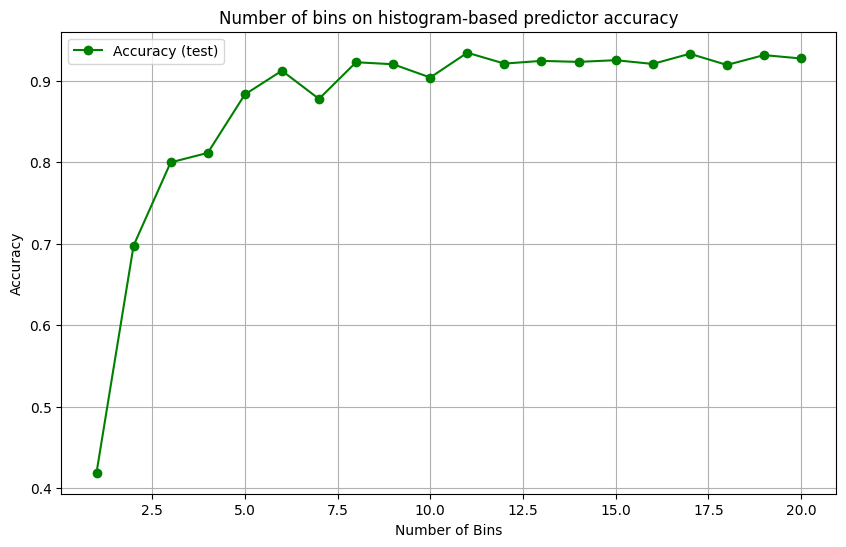

In [76]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(nbins_range, accuracies, marker='o', linestyle='-', color='green', label='Accuracy (test)')
plt.title('Number of bins on histogram-based predictor accuracy')
plt.xlabel('Number of Bins')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()